Data prep and Import Packages

In [16]:
from data_funcs import preprocess, cluster_feature_preprocess
from clustering import number_clusters_vis, kmeans_cluster, cluster_count_vis, cluster_preferences_vis, ks_clustering_test
import pandas as pd

customer_ref = 'data/WSA_data_customer.csv'
data_ref = 'data/WSA_data_order.csv'

# preprocess and data checks
cust_data, order_data = preprocess(customer_ref, data_ref)

# filter to dormant customers
order_data = order_data.merge(cust_data[['ACCOUNT_ID','ENGAGEMENT_SEGMENT']], left_on='ACCOUNT_ID', right_on='ACCOUNT_ID', how='inner')
order_data = order_data[order_data['ENGAGEMENT_SEGMENT']=='dormant']

Obtain our LLM (GPT-4o) category mappings

In [17]:
# use chat gpt with prompting to map our merchants into broad groups
merchants_mapping = pd.read_csv('data/merchants_mapping.csv')

# Join the mapping table onto the original table
order_data_merged = order_data.merge(merchants_mapping, left_on='MERCHANT_CATEGORY', right_on='Original Category', how='left')

# Check for missing mappings
missing_mappings = order_data_merged[order_data_merged['New Category'].isnull()]
print(f"Missing mappings: {missing_mappings.shape[0]}")

Missing mappings: 0


In [27]:
merchants_mapping.head(10)

,Original Category,New Category
0,Automotive Tire Stores,Automotive
1,Misc. Food Stores – Convenience Stores and Spe...,Food & Beverage
2,Fast Food Restaurants,Food & Beverage
3,Video Game Arcades/Establishments,Entertainment & Recreation
4,News Dealers and Newsstands,Retail
5,"Package Stores – Beer, Wine, and Liquor",Food & Beverage
6,"Grocery Stores, Supermarkets",Food & Beverage
7,Service Stations ( with or without ancillary s...,Automotive
8,Petroleum and Petroleum Products,Automotive
9,Eating places and Restaurants,Food & Beverage


Feature Engineering and Preprocess for clustering

In [18]:
# other transformations prior to metric calculations - calculated preference_score metric
user_category_df = cluster_feature_preprocess(order_data_merged)

# Pivot the dataframe to get a matrix of user-category preference scores
preference_matrix = user_category_df.pivot(index='ACCOUNT_ID', columns='New Category', values='preference_score').fillna(0)

In [28]:
preference_matrix

New Category,Apparel & Accessories,Automotive,Education & Training,Entertainment & Recreation,Finance & Insurance,Food & Beverage,Health & Beauty,Home & Garden,Professional & Business Services,Real Estate & Rental,Retail,Services,Technology & Electronics,Transportation & Logistics,Travel & Lodging
ACCOUNT_ID,,,,,,,,,,,,,,,
106069075,0.0,0.000000,0.0,0.0,0.0,0.000000,0.529284,0.0,0.0,0.0,0.470716,0.000000,0.000000,0.0,0.000000
106625800,0.0,0.422939,0.0,0.0,0.0,0.577061,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
106710100,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.000000
106737575,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
106743975,0.0,0.000000,0.0,0.0,0.0,0.500000,0.000000,0.5,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111918225,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.283257,0.014908,0.0,0.701835
111918700,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.000000
111919150,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


In [25]:
user_category_df[user_category_df['ACCOUNT_ID']=='106803750']

,ACCOUNT_ID,New Category,frequency,average_recency,weighted_recency,preference_score
22,106803750,Automotive,1,0.397695,0.602305,0.121937
23,106803750,Food & Beverage,1,0.000000,1.000000,0.202450
24,106803750,Retail,2,1.000000,0.000000,0.000000
25,106803750,Technology & Electronics,4,0.165706,0.834294,0.675613


Elbow and Silhouette - Optimal clusters

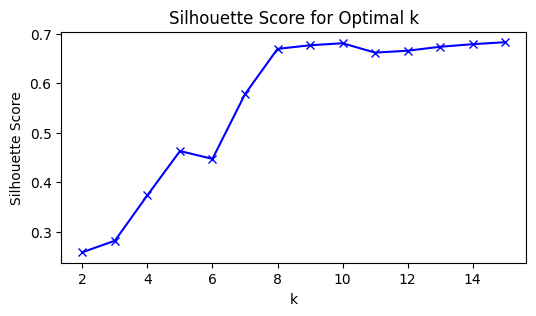

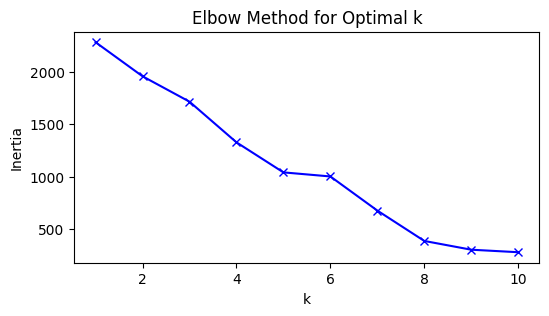

In [11]:
# check how many clusters we should use
# decide on number of clusters to use - optimal = 8
number_clusters_vis(preference_matrix, 2, 16)

Run Clustering - and check results

In [12]:
# run clustering with data and chosen amount of clusters
cluster_category_preferences, cluster_account_counts = kmeans_cluster(user_category_df, preference_matrix, 8)
cluster_category_preferences.head()

New Category,Apparel & Accessories,Automotive,Education & Training,Entertainment & Recreation,Finance & Insurance,Food & Beverage,Health & Beauty,Home & Garden,Professional & Business Services,Real Estate & Rental,Retail,Services,Technology & Electronics,Transportation & Logistics,Travel & Lodging
cluster,,,,,,,,,,,,,,,
0,0.025289,0.028809,0.066400,0.039883,NaN,0.041557,0.049513,0.032991,0.029333,0.103659,0.348511,0.047224,0.020242,0.061701,0.104888
1,0.020799,0.011121,NaN,0.030640,NaN,0.012219,0.046402,0.529218,0.107919,NaN,0.030577,0.068358,0.002486,0.094959,0.045302
2,0.036636,0.065032,0.050439,0.037316,0.042396,0.394276,0.050677,0.039903,0.037354,0.026600,0.060141,0.039767,0.030620,0.052569,0.036274
3,0.027717,0.032655,0.000000,0.019749,NaN,0.044656,0.471684,0.058024,0.178139,NaN,0.058863,0.064145,0.013390,0.000000,0.030979
4,0.050281,0.444247,0.006625,0.066683,0.000000,0.073877,0.064642,0.034469,0.053037,NaN,0.069669,0.075755,0.028553,0.010042,0.022119


Check that our clusters are each significantly different to overall data set

In [13]:
ks_clustering_test(user_category_df)

Cluster: 0 {'ks_stat': 0.1531856814531806, 'p_value': 5.476546217389743e-22}
Cluster: 1 {'ks_stat': 0.38733625726733595, 'p_value': 4.235680643024442e-61}
Cluster: 2 {'ks_stat': 0.16438834066190755, 'p_value': 2.111616870717917e-51}
Cluster: 3 {'ks_stat': 0.23287504968837885, 'p_value': 5.539928285538793e-25}
Cluster: 4 {'ks_stat': 0.08928390647381289, 'p_value': 7.346567924183056e-05}
Cluster: 5 {'ks_stat': 0.14834631845212803, 'p_value': 2.5402019900169875e-10}
Cluster: 6 {'ks_stat': 0.21290562298736684, 'p_value': 2.809748657935477e-12}
Cluster: 7 {'ks_stat': 0.1525111928312957, 'p_value': 6.468874704480374e-24}


Visualise Preferences Results

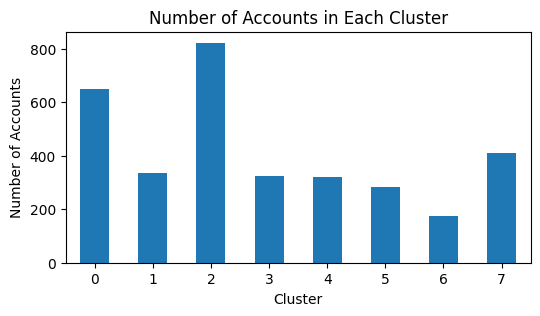

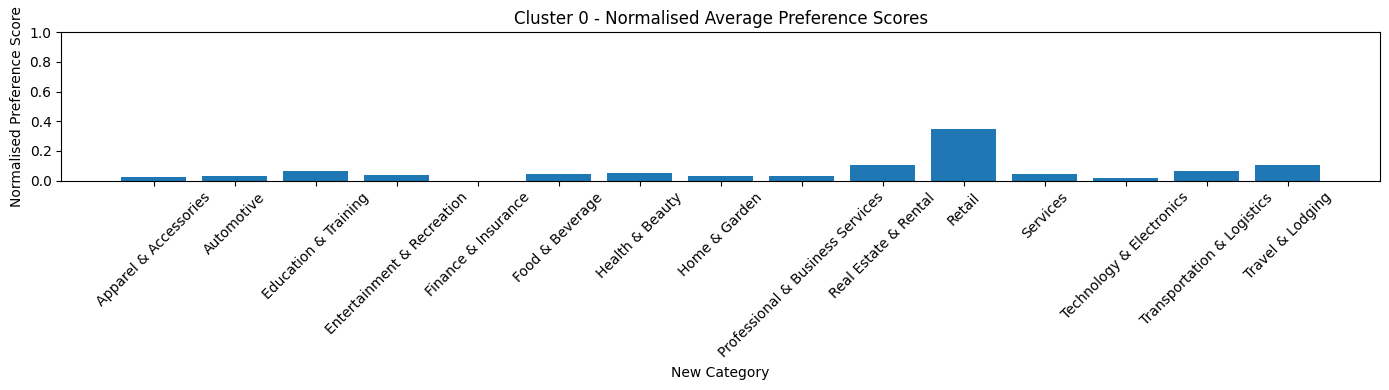

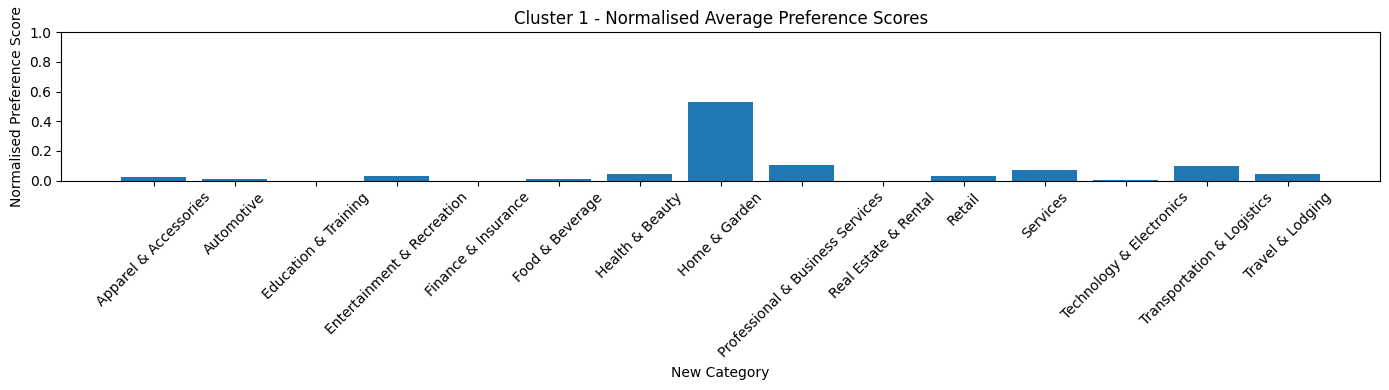

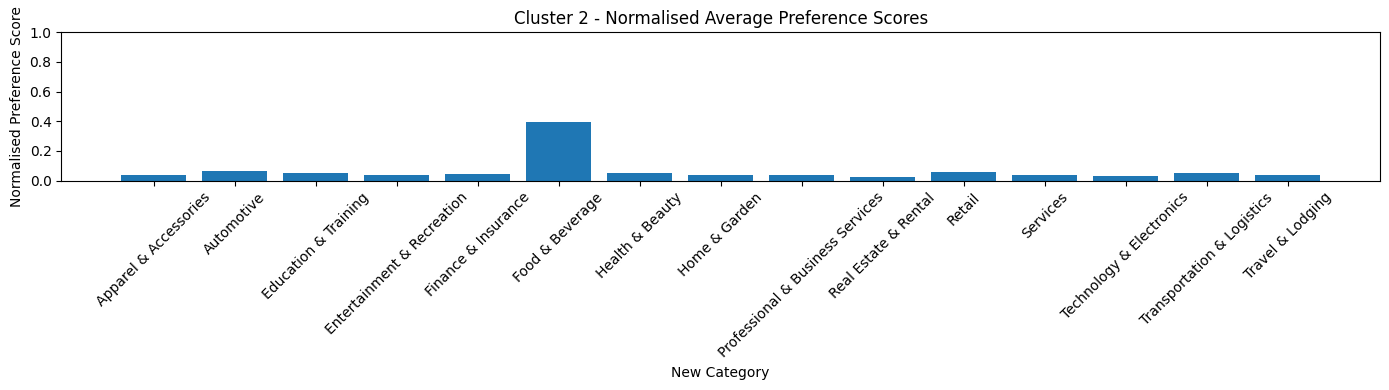

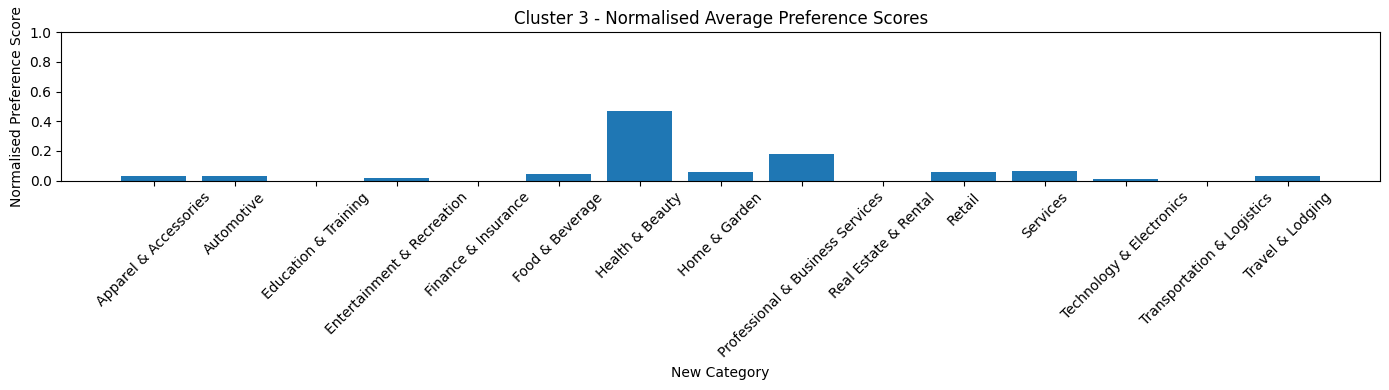

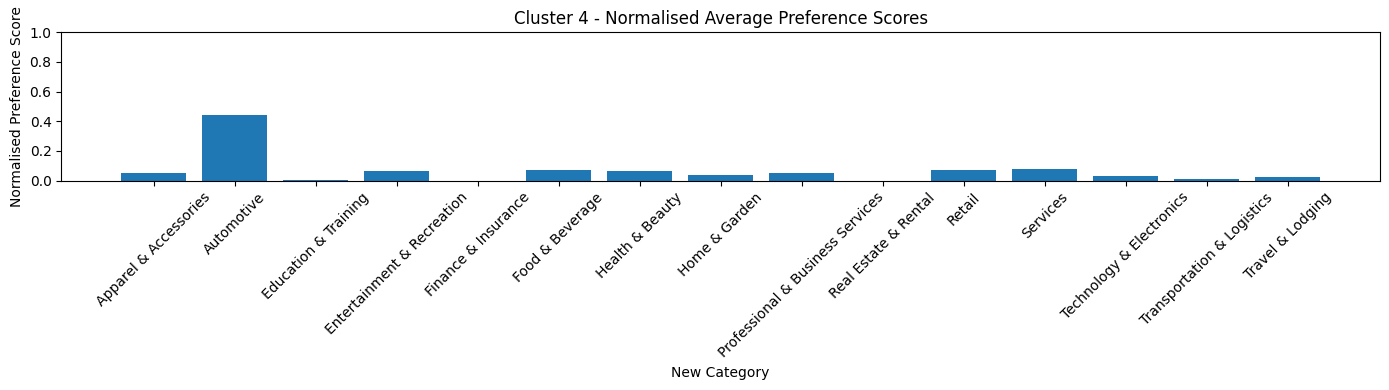

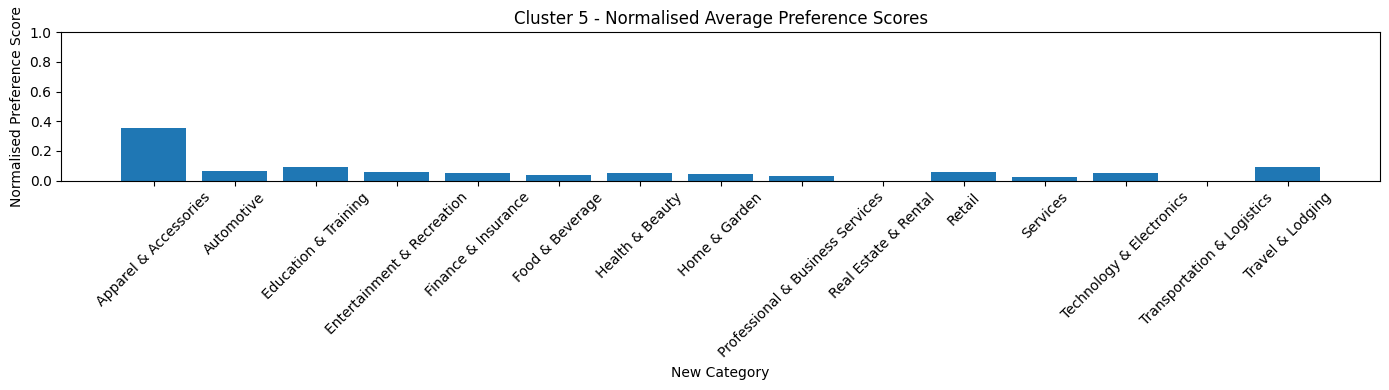

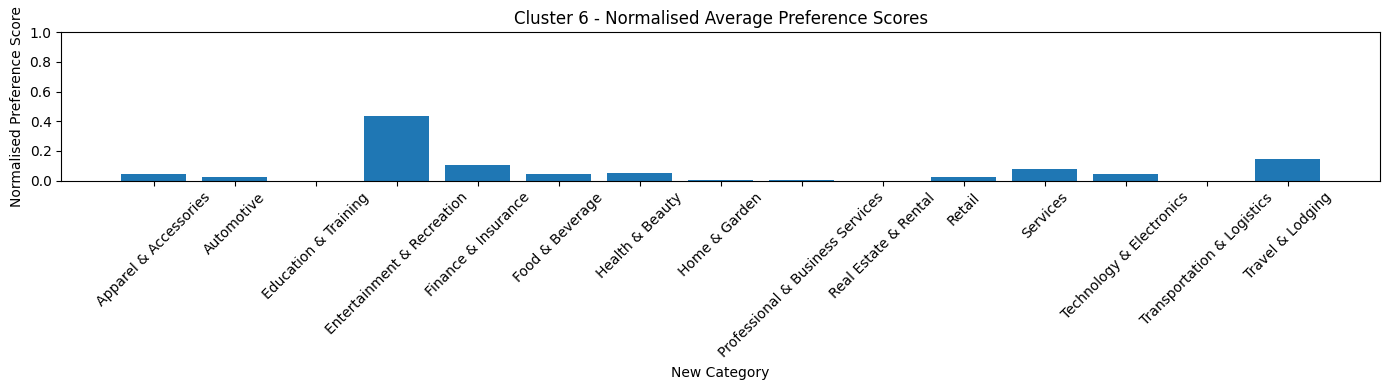

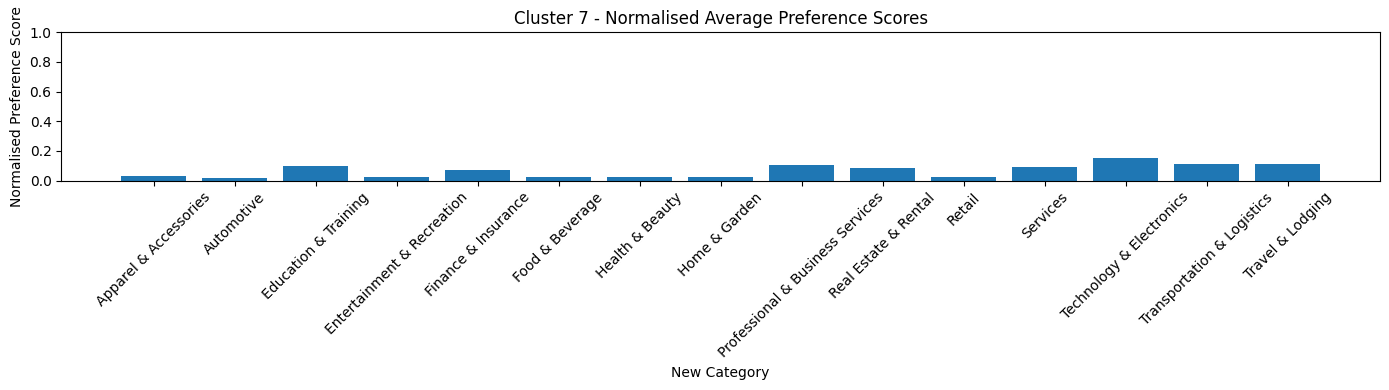

In [14]:
# visualise results
cluster_count_vis(cluster_account_counts)
cluster_preferences_vis(cluster_category_preferences)
